In [1]:
import random as r
import json, os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib as mpl

from architecture.NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE

# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              #'font.family': 'serif',
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

# Boolean determining if figures should be saved (all figures or summary-only)
saveallfigs = False
savesumfigs = True

In [2]:
def load_data(data_file_prefix):
    # Step 1. Load in the data
    train_u = np.load("{}_train1_u.npy".format(data_file_prefix)).astype(np.float32)
    train_f = np.load("{}_train1_f.npy".format(data_file_prefix)).astype(np.float32)
    val_u = np.load("{}_val_u.npy".format(data_file_prefix)).astype(np.float32)
    val_f = np.load("{}_val_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u = np.load("{}_test2_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f = np.load("{}_test2_f.npy".format(data_file_prefix)).astype(np.float32)

    train_data = [train_u, train_f]
    val_data = [val_u,   val_f]
    test1_data = [test_u1, test_f1]
    test2_data = [test_u,  test_f]

    return train_data, val_data, test1_data, test2_data
    
def organize_data(data):
    return [{'x': [u, f], 
             'y': [u, f, f, u]} \
             for (u,f) in data]


In [3]:
def find_sample(u,f, full_model, mode='worst', meanidx=None):
    _, _, pred_f, pred_u = full_model.predict(x=[u, f])

    f_scores = rel_mse(pred_f, f)
    u_scores = rel_mse(pred_u, u)
    
    score = np.abs(f_scores) + np.abs(u_scores)
    mean = np.mean(score)
    
    if mode.lower() == 'worst':
        idc = np.argmax(score)
    elif mode.lower() == 'best':
        idc = np.argmin(score)
    elif mode.lower() == 'mean':
        if meanidx:
            idcs = np.where(np.abs(score-mean) < 0.01*np.std(score))[0]
            idc = idcs[meanidx]
        else:
            idc = np.argmin((score-mean)**2)
        print(idc)
    else:
        print('{} mode not supported.'.format(mode))
        idc = np.argmin(score)
        
    return idc


In [4]:
def get_latent_representation(full_model, sample_u, sample_F):
    # Grab the u-encoder and f-encoder
    u_enc = full_model.layers[0]
    F_enc = full_model.layers[2]
    # Compute v and f
    v = tf.matmul(u_enc(sample_u), full_model.u_Reduce).numpy()
    f = tf.matmul(F_enc(sample_F), full_model.F_Reduce).numpy()
    # Return the two vectors!
    return v, f

In [5]:
# Set data files and expt name
data_file_prefix = './data/S0-Oscillator'

# Model directory
save_prefix = 'results' + os.path.sep

# Load the training and validation data
train_data, val_data, test1_data, test2_data = load_data(data_file_prefix)

# Organize the data
datasets = organize_data([train_data, val_data, test1_data, test2_data])

# Specify the data to use for u, F
u, F = train_data

# Grab the row corresponding to a specific u or F
i = 14
sample_u = u[i:i+1,:]
sample_F = F[i:i+1,:]

In [6]:
%%time

# List for saving results
latents = []

# Iterate through all the model results, and save them!
for modelnum in range(1, 100):
    expt_name = "S0-{}".format(str(modelnum))
    # Load the best model
    model_path = save_prefix + os.path.sep + expt_name + os.path.sep + "final_model"
    full_model = tf.keras.models.load_model(model_path, 
                                         custom_objects={"NormalizedMeanSquaredError": NMSE})
    v, f = get_latent_representation(full_model, sample_u, sample_F)
    latents.append((v, f))

OSError: SavedModel file does not exist at: results\\S0-60\final_model/{saved_model.pbtxt|saved_model.pb}

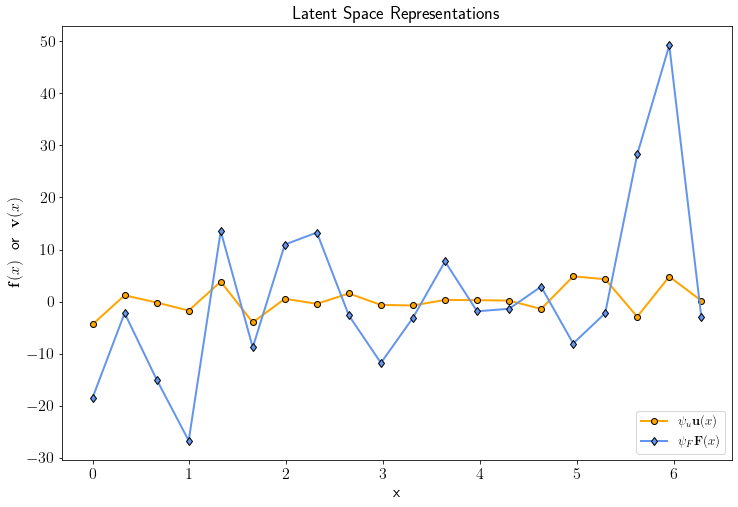

In [9]:
x = np.linspace(0, 2*np.pi, 20)

# Some plotting options
aec_line = dict(color='orange', lw=2, marker='o', mfc='orange', mec='black')
aec_line2 = dict(color='cornflowerblue', lw=2, marker='d', mfc='cornflowerblue', mec='black')

# And now plot it!
fig = plt.figure()

plt.title("Latent Space Representations")

plt.plot(x, v.flatten(), **aec_line, label=r'$\mathbf{\psi}_u \mathbf{u}(x)$')
plt.plot(x, f.flatten(), **aec_line2, label=r'$\mathbf{\psi}_F \mathbf{F}(x)$')

#plt.legend(loc='center', bbox_to_anchor=(1.1,0.5))
plt.legend(loc='lower right')
plt.ylabel(r"$\mathbf{f}(x)\;$ or $\;\mathbf{v}(x)$")
plt.xlabel("x")

plt.show()

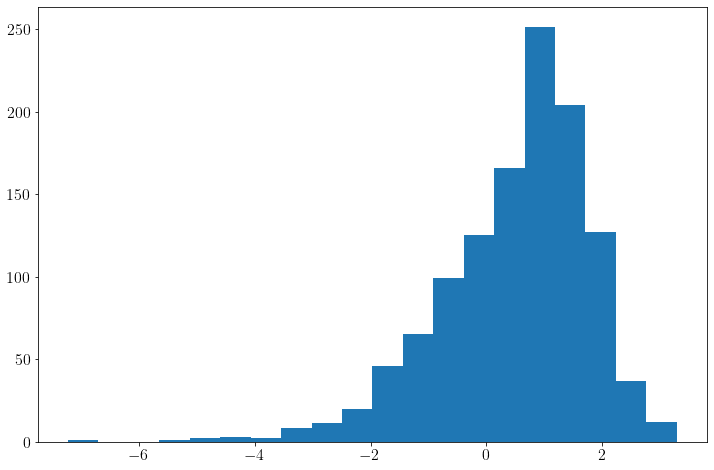

In [10]:
vs = [latent[0].reshape(-1) for latent in latents]
fs = [latent[1].reshape(-1) for latent in latents]


vs = [np.abs(v) for v in vs]

vs = [np.log(v) for v in vs]

vs = np.asarray(vs[:100]).flatten()

plt.hist(vs, bins=20, histtype='barstacked')
#plt.plot(vs)

plt.show()

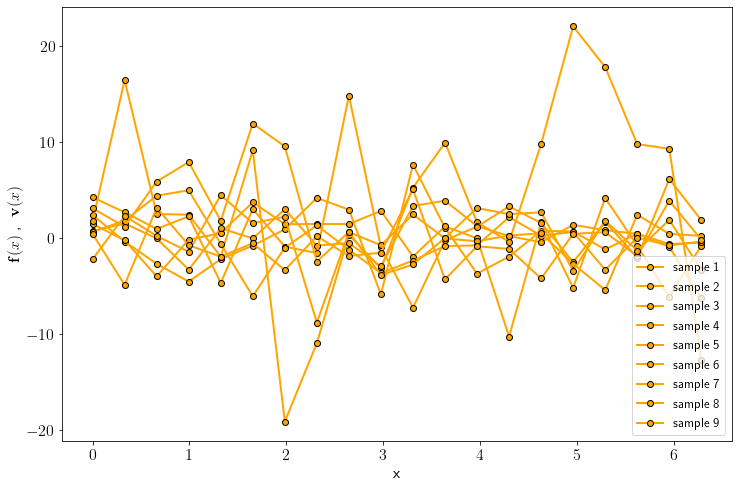

In [14]:
x = np.linspace(0, 2*np.pi, 20)

# Some plotting options
aec_line = dict(color='orange', lw=2, marker='o', mfc='orange', mec='black')
aec_line2 = dict(color='cornflowerblue', lw=2, marker='d', mfc='cornflowerblue', mec='black')

# And now plot it!
fig = plt.figure()


# Iterate through all the model results, and save them!
for modelnum in range(1, 10):
    expt_name = "S0-{}".format(str(modelnum))
    # Load the best model
    model_path = save_prefix + os.path.sep + expt_name + os.path.sep + "final_model"
    full_model = tf.keras.models.load_model(model_path, 
                                         custom_objects={"NormalizedMeanSquaredError": NMSE})
    v, f = get_latent_representation(full_model, sample_u, sample_F)
    
    plt.plot(x, v.flatten(), **aec_line, label=r'sample {}'.format(modelnum))
    #plt.plot(x, f.flatten(), **aec_line2, label=r'$\mathbf{\psi}_F \mathbf{F}(x)$ - sample {}'.format(modelnum))

#plt.legend(loc='center', bbox_to_anchor=(1.1,0.5))
plt.legend(loc='lower right')
plt.ylabel(r"$\mathbf{f}(x)\;$, $\;\mathbf{v}(x)$")
plt.xlabel("x")

plt.show()